In [1]:
#import tensorflow as tf
import os
import gc
import sys
import time
import datetime

import tensorflow as tf
#tf.disable_v2_behavior()

from tensorflow.python.client import device_lib
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
# import tensorflow_model_optimization as tfmot #require tensorflow_model_optimization module
#import theano.tensor as th
#import theano


import numpy as np
import pandas as pd
from pandas import Series, DataFrame

#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import keras
from keras.utils import multi_gpu_model
#from keras.utils.training_utils import multi_gpu_model
from keras.layers import BatchNormalization, GlobalAvgPool2D, GlobalAveragePooling2D, Add, BatchNormalization
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.activations import softmax
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, DepthwiseConv2D
from keras.layers.core import Flatten, Dropout, Reshape
from keras.preprocessing import image
from keras.engine.topology import Layer
from keras import regularizers
from keras import Input
from keras.layers.core import Lambda
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as kb

import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#from scipy.misc import toimage, imread
#from skimage.transform import resize
#from scipy.misc import toimag 


Using TensorFlow backend.


In [2]:
keras.__version__

'2.2.4'

In [3]:
tf.__version__

'1.6.0'

In [4]:
import sys

print(sys.version)

3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


In [5]:
def  optimize_for_inference(input_graph_def, inputs, ouputs) :
    output_graph_def = optimize_for_inference_lib.optimize_for_inference(      
        input_graph_def,      
        inputs,      
        ouputs,       
        tf.float32.as_datatype_enum)
    return output_graph_def

In [6]:
def freeze_trained_model(session, keep_var_names=None, output_names=None, clear_devices=True):
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        print(output_names)
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ''
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [208]:
def ListupDataFiles(root) :
    try :
        subs = []
        returnlist = []
        files = os.listdir(root)
        
        for fi in files :
            fullpath = os.path.join(root, fi)
            if(os.path.isdir(fullpath)) :                
                subs.append(fullpath)                
            else :
                ext = os.path.splitext(fi)[-1]
                if ext =='.bmp' :
                    returnlist.append(fullpath)
        
        for sub in subs :
            sublist = ListupDataFiles(sub)
            returnlist.extend(sublist)
    except PermissionError:
        pass
    
    return returnlist

# 7. 모델 사용하기(Predict)

In [7]:
def CheckValidationEach(path, model):
    
    displaystep = 10
    
    print("Predict each data")     
    
    starttime = time.time()
    
    validation_filelist = os.listdir(path)
    
    validation_filelist = [file for file in  validation_filelist if file.endswith(".bmp")]
    
    correctcnt=0
    incorrectcnt=0
    count = 0;
    
    predict_results = []
    currect_result = []
    
    for filename in validation_filelist :
        maxidx=0
        interprocesstime = time.time()
                
        
        #preprocessing - image array and label generate
        img = image.load_img(path+'/'+filename)
        arr_img = image.img_to_array(img)
        #arr_img /= 255.0
        label = int(((filename.split('.'))[0].split('_'))[2])        
        currect_result.append(label)
        
        #predict data
        validation_result = model.predict(arr_img.reshape(1,256,256,3))
        validation_result *= 100
        predict_results.append(validation_result)
           
        #result processing
        for idx in range(0,(validation_result.shape[1])):
            if validation_result[0,maxidx]<validation_result[0,idx] :
                maxidx = idx

        if maxidx == label :
            correctcnt+=1
        else :
            incorrectcnt+=1
                       
        count += 1        
        
        
        percent = count/len(validation_filelist);
        arrow  = '-' * int(round(percent * 20)-1) +'>'
        spaces = ' ' * (20 - len(arrow))
        sys.stdout.write("\rProgress : [{0}] {1}/{2}({3}%), Corr={4},Incorr={5},Acc = {6:7.3f},spt={7:.2f},ispt={8:.2f}".format(
        arrow + spaces, 
        count,
        len(validation_filelist),
        int(round(percent*100)),
        correctcnt,
        incorrectcnt, 
        (correctcnt /(correctcnt+incorrectcnt)),
        (time.time()-starttime),
        (time.time()-interprocesstime)
        )
        )
           #if len(validation_filelist) > count+1 :
           #    sys.stdout.flush()
    
        if (count % 200) == 0 :
            gc.collect()
            
    print("\rPredict complete {}sec".format((time.time()-starttime)))
    
    result_str = DisplyPerdictResult(predict_results,currect_result, validation_filelist,path)
    gc.collect()    
    return predict_results,currect_result, validation_filelist, result_str

In [8]:
def DisplyPerdictResult(results,correct,files,basepath):
    prdictresult = ''
    
    for index in range(0, len(results)) : 
        maxidx=0
        
        for idx in range(1, len(results[0][0])) :
            if results[index][0][maxidx]<results[index][0][idx] :
                maxidx = idx
        
        string = "Noise:{:7.3f} Void:{:7.3f},Surface:{:7.3f},Corona:{:7.3f},NFloating:{:7.3f},predict:{},correct:{},file = {}".format(
            results[index][0][0],results[index][0][1],results[index][0][2],results[index][0][3],results[index][0][4],
            maxidx,
            correct[index],
            files[index]
            )
        
        #string = "Noise:{:7.3f} Void:{:7.3f},Surface:{:7.3f},Corona:{:7.3f},predict:{},correct:{},file = {}".format(
        #    results[index][0][0],results[index][0][1],results[index][0][2],results[index][0][3],
        #    maxidx,
        #    correct[index],
        #    files[index]
        #    )
        
        prdictresult = prdictresult + '\n' + string         
            
        #print(string)
        
    return prdictresult

In [9]:
def DisplyPerdictIncorrectResult(results, correct, files, basepath, marjin = 90.0):
     for index in range(0, len(results)) : 
        maxidx=0
        
        for idx in range(1, len(results[0][0])) :
            if results[index][0][maxidx]<results[index][0][idx] :
                maxidx = idx
            
        if maxidx != correct[index] or results[index][0][maxidx] <= marjin :
            if maxidx != correct[index] :
                print("No:{:7.3f} Vo:{:7.3f},Su:{:7.3f},Co:{:7.3f},NF:{:7.3f},P = {},C = {}, acc = {}, file = {}".format(
                results[index][0][0],results[index][0][1],results[index][0][2],results[index][0][3],
                results[index][0][4],
                maxidx,
                correct[index],
                'Fail',
                files[index]
                ))
                #img = image.load_img(basepath+'/'+files[index])
                #img.show()
            else :
                print("No:{:7.3f} Vo:{:7.3f},Su:{:7.3f},Co:{:7.3f},NF:{:7.3f},P = {},C = {}, acc = {}, file = {}".format(
                results[index][0][0],results[index][0][1],results[index][0][2],results[index][0][3],
                results[index][0][4],
                maxidx,
                correct[index],
                'Succ',
                files[index]
                ))
                #img = image.load_img(basepath+'/'+files[index])
                #img.show()

In [313]:
def LoadImageDatas(files, print_filse =True, filt = 0) :
    #aa = ListupDataFiles('PDImages/20201106_images')
    
    filtval = 1
    images =[]
    labels =[]
    for filename in files :   
        
        if filtval%filt == 0 :
        
            img = image.load_img(filename)
            x = image.img_to_array(img)
            #x /= 255.0
            #x = np.expand_dims(x, axis=0)
            images.append(x)
            #print(os.path.split(filename))
            label = int(((os.path.split(filename)[1].split('.'))[0].split('_'))[2])        
            labels.append(label);

            if print_filse == True :
                print("File = {:30s}, Label = {}".format(
                 filename, label
                )
                )
        filtval = filtval + 1
    rt_images = np.array(images)
    rt_labels = np.array(labels)
    
    print('Image loaded count : ' , rt_images.shape)
    print('Label loaded count : ' , rt_labels.shape)
    return rt_images, rt_labels
    

In [11]:
def LoadImageData(filepath) :
    img = image.load_img(filepath)
    x = image.img_to_array(img)
    rt_images = np.array(x)
    return rt_images

In [12]:
def labelcheck (name, target) :
    label_0 = 0;
    label_1 = 0;
    label_2 = 0;
    label_3 = 0;
    label_4 = 0;
    total = 0
    for index in range(target.shape[0]) :  
        total += 1
        if target[index][0] > 0.0 :
            label_0 += 1
        elif target[index][1] > 0.0 :
            label_1 += 1
        elif target[index][2] > 0.0 :
            label_2 += 1
        elif target[index][3] > 0.0 :
            label_3 += 1
        elif target[index][4] > 0.0 :
            label_4 += 1
    print("{} =>0 : {}, 1 : {}, 2 : {}, 3 : {}, 4 : {}, total : {}".format(
         name, label_0, label_1,label_2,label_3, label_4,total
    )
    )

In [13]:
def add_activation(x, use_elu = False) :
    if use_elu :
        x = keras.activations.elu(alpha=1)
    else :    
        x = Activation('relu')(x)
    return x

In [14]:
#kernel_initializer='he_normal',
#kernel_regularizer=regularizers.l2(0.01)

def Depthwise_bn_relu(x, s, padd, use_elu = False) :
    x= DepthwiseConv2D((3,3), strides = (s,s) , padding = padd, use_bias = False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001))(x)
    x= BatchNormalization()(x)
    x= add_activation(x)
    return x

In [15]:
def Pointwise_bn_relu(x, num_of_filter, use_elu = False) :
    x= Conv2D(num_of_filter, (1,1), strides=(1,1), padding='same', use_bias = False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001))(x)
    x= BatchNormalization()(x)
    x= add_activation(x)
    return x

In [16]:
class FeatureExtractor(Layer):

    def __init__(self, **kwargs):
        self.input_spec = [keras.layers.InputSpec(ndim=4)]
        super().__init__(**kwargs)
    
    def build(self, input_shape):               
        self.trainable = False        
        #print('input_shape : ', input_shape)
        self.b = input_shape[0]
        self.h = input_shape[1]
        self.w = input_shape[2]
        #print("b :" , self.b,"h :" , self.h,"w :" , self.w)
        self.x = tf.range(self.w, delta= 1.0/self.w, dtype='float32')
        self.y = tf.range(self.h, delta= 1.0/self.h, dtype='float32')
               
        super(FeatureExtractor, self).build(input_shape)  # 끝에서 꼭 이 함수를 호출하십시오
    def Calculate(self, d) :
        #print(tf.shape(d))
        xp = tf.reduce_sum(d,axis=0)
        yp = tf.reduce_sum(d,axis=1)

        #centroid
        ltt_x = self.x*xp
        ltt_y = self.y*yp
        cx  = tf.reduce_sum(ltt_x) / tf.reduce_sum(xp)    
        cy = tf.reduce_sum(ltt_y) / tf.reduce_sum(yp)

        #standard deviation
        x2 = tf.pow((self.x-cx),2)
        y2 = tf.pow((self.y-cy),2)

        sx = tf.sqrt( tf.reduce_sum(x2*xp)/tf.reduce_sum(xp) )
        sy = tf.sqrt( tf.reduce_sum(y2*yp)/tf.reduce_sum(yp) )

        #skewness
        x3 = tf.pow((self.x-cx),3)
        y3 = tf.pow((self.y-cy),3)

        skx = tf.reduce_sum(xp*x3)/(tf.reduce_sum(xp) * tf.pow(sx,3))
        sky = tf.reduce_sum(yp*y3)/(tf.reduce_sum(yp) * tf.pow(sy,3))

        #Kurtosis
        x4 = tf.pow((self.x-cx),4)
        y4 = tf.pow((self.y-cy),4)

        kx = tf.reduce_sum(xp*x4)/(tf.reduce_sum(xp) * tf.pow(sx,4))
        ky = tf.reduce_sum(yp*y4)/(tf.reduce_sum(yp) * tf.pow(sy,4))

        rowrlt = tf.stack([cx, cy, sx,sy,skx,sky,kx,ky], axis=0)
        return rowrlt
        
    def call(self, inputs, training=None, mask=None):                             
            
        rltlist = tf.map_fn(self.Calculate, back_prop=False,elems=inputs)
        
       # print("Tv", tf.shape(tv), ",", tv.get_shape()[0])
       # rltlist = []
       # for i in range(0, tv.get_shape()[0]) :              
       #     rlt = self.Calculate(tf.reshape(inputs[i]))                   
       #     rltlist.append(rlt)            
       # return tf.stack(rltlist)
        
        #print (rltlist.get_shape())
        return rltlist
  
    def compute_output_shape(self, inshape):
        return (inshape[0], 8)

In [17]:
class ImageCorrlelation(Layer) :
     def __init__(self, **kwargs):
        self.input_spec = [keras.layers.InputSpec(ndim=4)]
        super().__init__(**kwargs)
    
     def build(self, input_shape):               
        self.trainable = False                               
        super(ImageCorrlelation, self).build(input_shape)  # 끝에서 꼭 이 함수를 호출하십시오
    
     def Calculate(self ,image) :    
        sub_1_xp = tf.reduce_sum( image[0],axis=0)
        sub_1_yp = tf.reduce_sum( image[0],axis=1)

        sub_2_xp = tf.reduce_sum(image[1],axis=0)
        sub_2_yp = tf.reduce_sum(image[1],axis=1)

        mx_x1 = tf.reduce_mean(sub_1_xp)
        mx_x2 = tf.reduce_mean(sub_2_xp)

        ax = tf.reduce_sum((sub_1_xp-mx_x1)*(sub_2_xp-mx_x2))
        bx = tf.reduce_sum( tf.pow(sub_1_xp - mx_x1,2))
        cx = tf.reduce_sum( tf.pow(sub_2_xp - mx_x2,2))

        mx_y1 = tf.reduce_mean(sub_1_yp)
        mx_y2 = tf.reduce_mean(sub_2_yp)

        ay = tf.reduce_sum((sub_1_yp-mx_y1)*(sub_2_yp-mx_y2))
        by = tf.reduce_sum( tf.pow(sub_1_yp - mx_y1,2))
        cy = tf.reduce_sum( tf.pow(sub_2_yp - mx_y2,2))

        ccx = tf.reduce_sum(ax) / tf.sqrt( tf.reduce_sum(bx * cx))
        ccy = tf.reduce_sum(ay) / tf.sqrt( tf.reduce_sum(by * cy))

        cc = tf.stack([ccx, ccy], axis=0)     
        return tf.truediv(cc, 100.0)
    
     def call(self, inputs, training=None, mask=None):                                     
        
        #print("corr call start")
        #rltlist = tf.map_fn(self.Calculate, back_prop=False ,elems= inputs)
        #print ("corr input " , inputs)
        
        #print ("corr input t1" , tf.stack([inputs[0], inputs[1]], axis = 0))
        
        #print ("corr input t2" , tf.stack([inputs[0], inputs[1]], axis = 1))
        
        rltlist = tf.map_fn(self.Calculate, back_prop=False,elems= tf.stack([inputs[0], inputs[1]], axis = 1))
        #rltlist = []
        #for i in range(0, self.b) :            
        #    rlt = self.Calculate(inputs[0][i], inputs[1][i])                                                   
        #    rltlist.append(rlt)  
        #return tf.stack(rltlist) # self.result     
        #print("corr call end")
        #print (rltlist.get_shape())
        return rltlist
    
     def compute_output_shape(self, inshape):
        #print("compute_output_shape", inshape[0][0])
        return ( inshape[0][0], 2)    

In [18]:
# 노이즈 날리는
class ImagefeatureExtraction(Layer) :
    
    def __init__(self,noiselevel = 200, **kwargs):        
        self.noiselevel = noiselevel
        super().__init__(**kwargs)    
    
    def build(self, input_shape ):               
        self.trainable = False
        self.h = input_shape[1]
        self.w = input_shape[2]
        
        self.half_w = int(self.w / 2)

        
        self.x = tf.range(0.0, 1.0, (1.0/self.half_w), dtype='float32')
        self.y = tf.range(0.0, 1.0, (1.0/self.h), dtype='float32')
                
        print("Noise level : " ,self.noiselevel )
        super(ImagefeatureExtraction, self).build(input_shape)  # 끝에서 꼭 이 함수를 호출하십시오
                
    def imagenoiseremove(self, row) :
        cnt = tf.count_nonzero(row)
        rlt = tf.cond(cnt < self.noiselevel ,lambda : row, lambda :tf.zeros((self.w)) )
        return rlt
    

    def calcualte_feature_true_fn(self, axisprojection_sum, projection_sum, projection, centroid, mult) :
        #standard deviation
        stddev= tf.sqrt(axisprojection_sum / projection_sum)
            
        x3 = tf.pow((mult-centroid),3)                
        skewness = tf.reduce_sum(projection * x3 ) / (projection_sum * tf.pow(stddev,3))

        x4 = tf.pow((mult-centroid),4)                
        kurtosis = tf.reduce_sum(projection * x4 ) / (projection_sum * tf.pow(stddev,4))
        
        return stddev, skewness, kurtosis

    def calcualte_feature_false_fn(self) :              
        return 0.0,0.0,0.0
    
    def generatesubimagefeature(self, proj_x, proj_y, proj_x_sum, proj_y_sum) :
        
        #centroid sub image left
        img_centroid_x = tf.reduce_sum((self.x*proj_x)) / proj_x_sum   
        img_centroid_y = tf.reduce_sum((self.y*proj_y)) / proj_y_sum
                
        img_centroid_x = tf.cond(  tf.is_nan(img_centroid_x) ,
                  lambda:  0.0,
                  lambda:  img_centroid_x
                )    
            
        img_centroid_y = tf.cond(  tf.is_nan(img_centroid_y) ,
                  lambda:  0.0,
                  lambda:  img_centroid_y
                )
        
        x2 = tf.pow((self.x-img_centroid_x),2)
        y2 = tf.pow((self.y-img_centroid_y),2)

        x2xp_sum = tf.reduce_sum(x2 * proj_x)
        y2yp_sum = tf.reduce_sum(y2 * proj_y)
                     
        img_std_x,img_skewness_x,img_Kurtosis_x =  tf.cond(   tf.equal(x2xp_sum, 0.0) ,
                      lambda:  self.calcualte_feature_false_fn(),
                      lambda:  self.calcualte_feature_true_fn(x2xp_sum, proj_x_sum, proj_x, img_centroid_x,self.x)
                    )    
        
        img_std_y,img_skewness_y,img_Kurtosis_y =  tf.cond(  tf.equal(y2yp_sum, 0.0) ,
                      lambda:  self.calcualte_feature_false_fn(),
                      lambda:  self.calcualte_feature_true_fn(y2yp_sum, proj_y_sum, proj_y, img_centroid_y,self.y)
                    ) 
            
        return img_centroid_x, img_centroid_y, img_std_x, img_std_y, img_skewness_x, img_skewness_y, img_Kurtosis_x, img_Kurtosis_y
    
    def generateCorrel(self, left_proj, right_proj, left_proj_mean, right_proj_mean ) :
        a = tf.reduce_sum( (left_proj-left_proj_mean) * (right_proj-right_proj_mean))
        b = tf.reduce_sum( tf.pow(left_proj - left_proj_mean,2) )
        c = tf.reduce_sum( tf.pow(right_proj - right_proj_mean,2) )

        cc = tf.reduce_sum(a) / tf.sqrt( tf.reduce_sum(b * c))
        
        cc = tf.cond(  tf.is_nan(cc) ,
                  lambda:  0.0,
                  lambda:  cc
                )    
            
        return cc
    
    def calc(self, image) :
        
        gimg =  tf.reshape(tf.image.rgb_to_grayscale(image), (self.h,self.w))     
        #그레이스켈링되고 
        
        #노이즈0으로 제거한 이미지 반환 self.imagenoiseremover 
        #remove background noise -> for each row if nonzero columnt > noise_level than zero else row
        timg =  tf.map_fn(self.imagenoiseremove, back_prop=False,elems= gimg)         
        
        #divide sub images
        left_img = timg[:,:self.half_w]
        right_img = timg[:,self.half_w:]
        
        #left image projection
        left_img_projection_x = tf.reduce_sum( left_img,axis=0)                                 
        left_img_projection_y = tf.reduce_sum( left_img,axis=1) 
            
        left_img_projection_x_sum = tf.reduce_sum(left_img_projection_x)
        left_img_projection_y_sum = tf.reduce_sum(left_img_projection_y)
            
        #right image projection
        right_img_projection_x = tf.reduce_sum( right_img,axis=0)
        right_img_projection_y = tf.reduce_sum( right_img,axis=1)
                
        right_img_projection_x_sum = tf.reduce_sum(right_img_projection_x)
        right_img_projection_y_sum = tf.reduce_sum(right_img_projection_y)    
        
       
        #mean projection
        mean_left_img_projection_x = tf.reduce_mean(left_img_projection_x)
        mean_right_img_projection_x = tf.reduce_mean(right_img_projection_x)
        
        mean_left_img_projection_y = tf.reduce_mean(left_img_projection_y)
        mean_right_img_projection_y = tf.reduce_mean(right_img_projection_y)
  
        
        # lambda : row, lambda :tf.zeros((self.w))
        ccx = self.generateCorrel(left_img_projection_x, right_img_projection_x, mean_left_img_projection_x,mean_right_img_projection_x)
        ccy = self.generateCorrel(left_img_projection_y, right_img_projection_y, mean_left_img_projection_y, mean_right_img_projection_y)
        
        
        left_img_centroid_x, left_img_centroid_y, left_img_std_x, left_img_std_y, left_img_skewness_x, left_img_skewness_y, left_img_Kurtosis_x, left_img_Kurtosis_y = self.generatesubimagefeature(left_img_projection_x, left_img_projection_y, left_img_projection_x_sum, left_img_projection_y_sum)
        
        right_img_centroid_x, right_img_centroid_y, right_img_std_x, right_img_std_y, right_img_skewness_x, right_img_skewness_y, right_img_Kurtosis_x, right_img_Kurtosis_y= self.generatesubimagefeature(right_img_projection_x, right_img_projection_y, right_img_projection_x_sum, right_img_projection_y_sum)
        
        return tf.stack([
            left_img_centroid_x,left_img_centroid_y, right_img_centroid_x,right_img_centroid_y,            
            left_img_std_x, left_img_std_y, right_img_std_x, right_img_std_y,
            left_img_skewness_x,left_img_skewness_y, right_img_skewness_x, right_img_skewness_y,
            left_img_Kurtosis_x, left_img_Kurtosis_y, right_img_Kurtosis_x, right_img_Kurtosis_y,
            ccx, ccy], axis=0)
    
    
    #call부터 
    def call(self, inputs, training=None, mask=None):                                     
  
        rltlist = tf.map_fn(self.calc, back_prop=False,elems= inputs)
        return rltlist 
         
    def compute_output_shape(self, inshape):
        #print("compute_output_shape", inshape[0])
        return ( inshape[0], 18)  
    #inshape[0] = 배치사이즈, 각 이미지마다 18개 정보 리턴

# MobilenetV1 Model

In [145]:
 def create_mobilnetv1_model(input_shape, n_class, use_elu = False, print_summary = True) :
    
  
    
    input_tensor = Input(input_shape, dtype='float32', name='input')    
    normalize_lamdalayer = Lambda(lambda x: x / 255.0, name="normalizeoutput")(input_tensor)                
    
    #statics layer    
    imgaefeatureconcatlayer = ImagefeatureExtraction(100)(normalize_lamdalayer)
    statlayerhidd = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(imgaefeatureconcatlayer)        
    statlayerhidd = Dense(64, kernel_regularizer=regularizers.l2(0.0001))(statlayerhidd)      
    statlayerhidd = BatchNormalization()(statlayerhidd)
    statlayerhidd = Activation(activation='relu')(statlayerhidd)
    statreshape = Reshape((1,1,64))(statlayerhidd)
        
    
    x = ZeroPadding2D(padding = ((0,1),(0,1)))(normalize_lamdalayer)           
    x = Conv2D(32,(3,3), strides = (2,2), padding='valid', use_bias = False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x=  add_activation(x)
            
    x = Depthwise_bn_relu(x,1,'same')
    x = Pointwise_bn_relu(x,64)
    x = ZeroPadding2D(padding = ((0,1),(0,1)))(x)
    
    x = Depthwise_bn_relu(x,2,'valid')
    x = Pointwise_bn_relu(x,128)
    
    x = Depthwise_bn_relu(x,1,'same')
    x = Pointwise_bn_relu(x,128)
    x = ZeroPadding2D(padding = ((0,1),(0,1)))(x)
    
    x = Depthwise_bn_relu(x,2,'valid')
    x = Pointwise_bn_relu(x,256)
    
    x = Depthwise_bn_relu(x,1,'same')
    x = Pointwise_bn_relu(x,256)
    x = ZeroPadding2D(padding = ((0,1),(0,1)))(x)
    
    x = Depthwise_bn_relu(x,2,'valid')
    x = Pointwise_bn_relu(x,512)
    
    #for _ in range(5) :
    #    x = Depthwise_bn_relu(x,1,'same')
    #    x = Pointwise_bn_relu(x,512)
    x = ZeroPadding2D(padding = ((0,1),(0,1)))(x)
    
    x = Depthwise_bn_relu(x,2,'valid')
    x = Pointwise_bn_relu(x,1024)
    x = Dropout(0.5)(x)
    
    # Dropout overfitting 방지하기 위해 노드 연결 줄이는
    x = Depthwise_bn_relu(x,2,'same')
    x = Pointwise_bn_relu(x,1024)
    x = Dropout(0.5)(x)
    
    x = GlobalAveragePooling2D(name='featureoutput')(x)
    x = Dropout(0.5)(x)
    x = Reshape((1,1,1024))(x)
                
    x = keras.layers.concatenate([x, statreshape])
    
    x = Dropout(0.4)(x)
    x = Conv2D(n_class, (1,1), strides= (1,1), padding = 'same', use_bias = False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001))(x)
    x = Activation('softmax')(x)
    
    x = Reshape((n_class,), name='classoutput')(x)
    
    model = Model(input_tensor, x)
    
    if print_summary== True :
        model.summary()
    
    return model

# START!!!!!!

In [369]:
keras.backend.clear_session() #그래프에 정의된 변수 Clear
tf.global_variables_initializer() #세션에 초기화 연산을 수행해야 하며, 변수에 메모리를 할당하고 초기값을 설정하는 역할
model = create_mobilnetv1_model((256,256,3), 5, use_elu=True , print_summary=True) #MobilenetV1 모델에 인자값 넘겨주고 return값 model에 저장

<tf.Operation 'init' type=NoOp>

Noise level :  100
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
normalizeoutput (Lambda)        (None, 256, 256, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 257, 257, 3)  0           normalizeoutput[0][0]            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 864         zero_padding2d_1[0][0]           
__________________________________________________________________________________________

In [21]:
target_data_set_dir = 'PDImages/2020_simulator_images'
target_data_set_dir = 'PDImages/2020_simulator_images_with_202011'
file_list = os.listdir(target_data_set_dir)
file_list = [file for file in file_list if file.endswith(".bmp")]
x_ori, y_ori = LoadImageDatas(target_data_set_dir,file_list, False)
n_labels = len(np.unique(y_ori))
y_one_hot_encoding = np_utils.to_categorical(y_ori,n_labels)
X_train, X_test, Y_train, Y_test = train_test_split(x_ori, y_one_hot_encoding, test_size = 0.1) # 테스트 셋과 학습셋을 분리 한다.
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2)
labelcheck("y_one_hot_encoding", y_one_hot_encoding)
labelcheck("Y_train", Y_train)
labelcheck("Y_val", Y_val)
labelcheck("Y_test", Y_test)

y_one_hot_encoding =>0 : 253, 1 : 207, 2 : 290, 3 : 313, 4 : 173, total : 1236
Y_train =>0 : 177, 1 : 150, 2 : 214, 3 : 222, 4 : 126, total : 889
Y_val =>0 : 50, 1 : 34, 2 : 47, 3 : 61, 4 : 31, total : 223
Y_test =>0 : 26, 1 : 23, 2 : 29, 3 : 30, 4 : 16, total : 124


In [ ]:
#new_20201106_images, new_20201106_labels = LoadImageDatas(aa, print_filse=False)

In [314]:
voidfilelist = ListupDataFiles('PDImages/20201106_images/Void')
voidimages, voidlabels = LoadImageDatas(voidfilelist,print_filse=False, filt= 2)

Image loaded count :  (728, 256, 256, 3)
Label loaded count :  (728,)


In [315]:
coronafilelist = ListupDataFiles('PDImages/20201106_images/Corona')
coronaimages, coronalabels = LoadImageDatas(coronafilelist,print_filse=False, filt= 1)

Image loaded count :  (612, 256, 256, 3)
Label loaded count :  (612,)


In [316]:
surfacefilelist = ListupDataFiles('PDImages/20201106_images/Surface')
surfaceimages, surfacelabels = LoadImageDatas(surfacefilelist,print_filse=False, filt= 1)

Image loaded count :  (420, 256, 256, 3)
Label loaded count :  (420,)


In [317]:
floationgfilelist = ListupDataFiles('PDImages/20201106_images/Floating')
floatingimages, floatinglabels = LoadImageDatas(floationgfilelist,print_filse=False, filt= 1)

Image loaded count :  (510, 256, 256, 3)
Label loaded count :  (510,)


In [366]:
noisefilelist = ListupDataFiles('PDImages/20201106_images/Noise')
noiseimages, noiselabels = LoadImageDatas(noisefilelist,print_filse=False, filt= 1)

Image loaded count :  (122, 256, 256, 3)
Label loaded count :  (122,)


In [367]:
new_20201106_images = np.concatenate((voidimages, coronaimages, surfaceimages, floatingimages, noiseimages ), axis=0)
new_20201106_images.shape

(2392, 256, 256, 3)

In [368]:
new_20201106_labels = np.concatenate((voidlabels, coronalabels, surfacelabels, floatinglabels, noiselabels ), axis=0)
new_20201106_labels.shape

(2392,)

In [337]:
n_labels = len(np.unique(new_20201106_labels))

new_20201106_labels_one_hot_encoding = np_utils.to_categorical(new_20201106_labels,n_labels)

X_train, X_test, Y_train, Y_test = train_test_split(new_20201106_images, new_20201106_labels_one_hot_encoding, test_size = 0.1) # 테스트 셋과 학습셋을 분리 한다.
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2)
labelcheck("y_one_hot_encoding", new_20201106_labels_one_hot_encoding)
labelcheck("Y_train", Y_train)
labelcheck("Y_val", Y_val)
labelcheck("Y_test", Y_test)

y_one_hot_encoding =>0 : 99, 1 : 728, 2 : 420, 3 : 612, 4 : 510, total : 2369
Y_train =>0 : 61, 1 : 527, 2 : 303, 3 : 453, 4 : 361, total : 1705
Y_val =>0 : 22, 1 : 129, 2 : 83, 3 : 99, 4 : 94, total : 427
Y_test =>0 : 16, 1 : 72, 2 : 34, 3 : 60, 4 : 55, total : 237


In [338]:
n_labels

5

# 3. 모델 학습과정 설정하기(손실함수, 최적화 등등)

In [370]:
sgdopt = SGD(lr=0.1)# SGD,Adam 등연전파 함수
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
#adadelta = Adadelta(lr=0.1)

#rmsprop = RMSprop(lr=0.0001)
rmsprop = RMSprop(lr=0.003)
#rmsprop = RMSprop(lr=0.01)

#try :
#    model = multi_gpu_model(model, gpus=3,cpu_merge=True)        
#    print("Parallel GPU mode run")
#except :
#    print("Single GPU mode run")


#RMSProp은 과거의 모든 기울기를 균일하게 더하지 않고 새로운 기울기의 정보만 반영하도록 해서 학습률이 크게 떨어져 0에 가까워지는 것을 방지하는 방법
model.compile(
    loss='categorical_crossentropy', #손실 평가 함수, 모델 오차측정
    optimizer=rmsprop,    # SGD,Adam 등연전파 함수
    #optimizer=sgdopt,
    #optimizer=adam,
    metrics=['accuracy']
)

#import datetime

#logdir = os.path.join('logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

#로그 생성하고 저장, 로그가 저장괼 디렉토리 위치 설정(사용X)
logdir = "./graph/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tb_hist = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True, write_images=True)
#model.fit(X_train, Y_train, epochs=1000, batch_size=10, validation_data=(X_val, Y_val), callbacks=[tb_hist])

#with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())


#Initialize tensorflow graph variables



In [371]:
#earlystopping
#val_loss가 4번동안 나아지지 않으면 훈련종료
#restore_best_weights이 True라면 training이 끝난 후, model의 weight를 monitor하고 있던 값이 가장 좋았을 때의 weight로 복원합니다

earlystop = EarlyStopping ( monitor = 'val_loss', min_delta = 0 , patience = 4, verbose=1, restore_best_weights = True)
lr_reduction = ReduceLROnPlateau(monitor= 'val_acc', patience=5, verbose=1, factor=0.2, min_lr=0.0001)
callbacks = [earlystop, lr_reduction]

#ReduceLROnPlateau
#모델의 개선이 없을 경우, 학습률을 조절해 모델의 개선을 유도하는 콜백함수
#callback호출 시 factor0.2 학습률을 5분의 1로 줄인다(새로운 learning rate = 기존 learning rate * factor)
#min_lr=0.0001 학습률의 하한선


In [41]:
#tf.initialize_all_variables().run(session=kb.get_session())    
#initop = tf.initialize_all_variables()

#tf.global_variables_initializer()

#sess = kb.get_session()
#sess.run(initop)


# 모델 학습 실행

In [372]:
#X_train, X_test, Y_train, Y_test
#세션에 초기화 연산을 수행해야 하며, 변수에 메모리를 할당하고 초기값을 설정하는 역할
tf.global_variables_initializer() 

history_learning = model.fit(
    #x_ori, y_one_hot_encoding,
    X_train,Y_train, 
    batch_size=200, epochs=20,
    #validation_split=0.1,
    validation_data=(X_val, Y_val),
    shuffle=True,
    verbose=1,
    callbacks = callbacks
  #  , callbacks=[tb_hist]
)

<tf.Operation 'init_1' type=NoOp>

Train on 1705 samples, validate on 427 samples
Epoch 1/20
1705/1705 [==============================] - 61s 36ms/step - loss: 1.6222 - acc: 0.7050 - val_loss: 0.9618 - val_acc: 0.9368
Epoch 2/20
1705/1705 [==============================] - 60s 35ms/step - loss: 0.7486 - acc: 0.9836 - val_loss: 0.7380 - val_acc: 0.9766
Epoch 3/20
1705/1705 [==============================] - 61s 36ms/step - loss: 0.6760 - acc: 0.9959 - val_loss: 0.6741 - val_acc: 0.9930
Epoch 4/20
1705/1705 [==============================] - 60s 35ms/step - loss: 0.6167 - acc: 0.9994 - val_loss: 0.6210 - val_acc: 0.9930
Epoch 5/20
1705/1705 [==============================] - 60s 35ms/step - loss: 0.5540 - acc: 1.0000 - val_loss: 0.5299 - val_acc: 0.9953
Epoch 6/20
1705/1705 [==============================] - 61s 36ms/step - loss: 0.4779 - acc: 1.0000 - val_loss: 0.4942 - val_acc: 0.9953
Epoch 7/20
1705/1705 [==============================] - 59s 34ms/step - loss: 0.3937 - acc: 0.9994 - val_loss: 3.6712 - val_acc: 0.4918
E

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [ ]:
print('inputs : ', [input.op.name for input in model.inputs])

In [ ]:
print('inputs : ', [output.op.name for output in model.outputs])

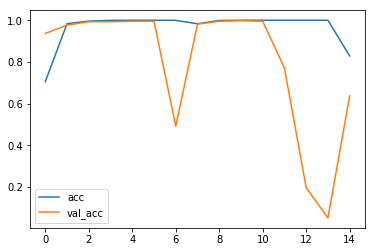

In [373]:
stats = DataFrame(history_learning.history)
imgplot = stats[['acc', 'val_acc']].plot()
fig = imgplot.get_figure()
fig.savefig("network_train_trend_acc.png")

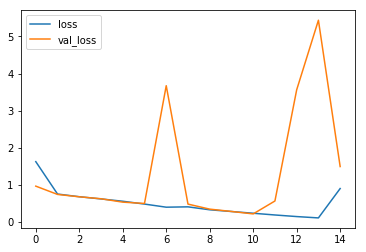

In [374]:
stats = DataFrame(history_learning.history)
imgplot = stats[['loss', 'val_loss']].plot()
fig = imgplot.get_figure()
fig.savefig("network_train_trend_loss.png")

# 모델평가하기

In [375]:
#X_train, X_test, Y_train, Y_test = t
evaluate = model.evaluate(X_train, Y_train)

1705/1705 [==============================] - 47s 28ms/step


In [376]:
print(evaluate)

[0.20400212996166822, 1.0]


In [377]:
#X_train, X_test, Y_train, Y_test = t
evaluate = model.evaluate(X_val, Y_val)

427/427 [==============================] - 12s 28ms/step


In [378]:
print(evaluate)

[0.2126291810209913, 0.9953161599485322]


In [379]:
#test셋으로 학습한 모델 평가하기(evaluate함수)
evaluate = model.evaluate(X_test, Y_test)

237/237 [==============================] - 7s 28ms/step


In [380]:
print(evaluate)

[0.22178481896466848, 0.9957805907172996]


In [381]:
evaluate = model.evaluate(x_ori, y_one_hot_encoding)

1236/1236 [==============================] - 35s 28ms/step


In [382]:
print(evaluate)

[3.563872254010543, 0.5339805829100625]


In [355]:
success_marjin = 90.0

In [ ]:
#returnresult, returncorrect, returnfiles, rslt = CheckValidationEach(target_data_set_dir, model)
returnresult, returncorrect, returnfiles, rslt = CheckValidationEach(target_data_set_dir, model)
DisplyPerdictIncorrectResult(returnresult, returncorrect, returnfiles, target_data_set_dir, success_marjin)
#f= open('2020_new_model_1102_rslt','w')
#f.write(rslt)
#f.close()

In [389]:
target_data_set_dir2 = 'PDImages/20201105_Void_sampes_1'
#returnresult, returncorrect, returnfiles, rslt = CheckValidationEach(target_data_set_dir, model)
returnresult, returncorrect, returnfiles, rslt = CheckValidationEach(target_data_set_dir2, model)
DisplyPerdictIncorrectResult(returnresult, returncorrect, returnfiles, success_marjin)
#f= open('2020_new_model_1102_rslt','w')
#f.write(rslt)
#f.close()

Predict each data
Predict complete 17.6927227973938sec8/428(100%), Corr=428,Incorr=0,Acc =   1.000,spt=17.69,ispt=0.03


In [390]:
target_data_set_dir2 = 'PDImages/20201105_Void_sampes_2'
#returnresult, returncorrect, returnfiles, rslt = CheckValidationEach(target_data_set_dir, model)
returnresult, returncorrect, returnfiles, rslt = CheckValidationEach(target_data_set_dir2, model)
DisplyPerdictIncorrectResult(returnresult, returncorrect, returnfiles, success_marjin)
#f= open('2020_new_model_1102_rslt','w')
#f.write(rslt)
#f.close()

Predict each data
Predict complete 0.9003801345825195sec5(100%), Corr=25,Incorr=0,Acc =   1.000,spt=0.90,ispt=0.04


In [391]:
target_data_set_dir2 = 'PDImages/20201105_Corona_samples_1'
#returnresult, returncorrect, returnfiles, rslt = CheckValidationEach(target_data_set_dir, model)
returnresult, returncorrect, returnfiles, rslt = CheckValidationEach(target_data_set_dir2, model)
DisplyPerdictIncorrectResult(returnresult, returncorrect, returnfiles, success_marjin)
#f= open('2020_new_model_1102_rslt','w')
#f.write(rslt)
#f.close()

Predict each data
Predict complete 0.7322902679443359sec1(100%), Corr=21,Incorr=0,Acc =   1.000,spt=0.73,ispt=0.04


In [ ]:
#returnresult, returncorrect, returnfiles, rslt = CheckValidationEach('ValTest', model)
#f= open('PRPD_Image_Patterns_MobilNetV1_kf_vald_V01_T02.txt','w')
#f.write(rslt)
#f.close()

#Test 20111106 pd pulse generator generate datas

In [383]:
#returnresult, returncorrect, returnfiles, rslt = CheckValidationEach(target_data_set_dir, model)
returnresult, returncorrect, returnfiles, rslt = CheckValidationEach('PDImages/20201106_images/Void', model)
DisplyPerdictIncorrectResult(returnresult, returncorrect, returnfiles, success_marjin)
#f= open('2020_new_model_1102_rslt','w')
#f.write(rslt)
#f.close()

Predict each data
Predict complete 59.39624333381653sec6/1456(100%), Corr=1454,Incorr=2,Acc =   0.999,spt=59.40,ispt=0.03
No:  0.619 Vo: 34.566,Su: 64.792,Co:  0.003,NF:  0.020,P = 2,C = 1, acc = Fail, file = Void_AD10A6220201106152700_1_img.bmp
No:  0.072 Vo: 28.503,Su: 71.411,Co:  0.001,NF:  0.013,P = 2,C = 1, acc = Fail, file = Void_AD20E6220201106152700_1_img.bmp


In [384]:
#returnresult, returncorrect, returnfiles, rslt = CheckValidationEach(target_data_set_dir, model)
returnresult, returncorrect, returnfiles, rslt = CheckValidationEach('PDImages/20201106_images/Corona', model)
DisplyPerdictIncorrectResult(returnresult, returncorrect, returnfiles, success_marjin)
#f= open('2020_new_model_1102_rslt','w')
#f.write(rslt)
#f.close()

Predict each data
Predict complete 25.64641785621643sec/612(100%), Corr=612,Incorr=0,Acc =   1.000,spt=25.65,ispt=0.03


In [385]:
#returnresult, returncorrect, returnfiles, rslt = CheckValidationEach(target_data_set_dir, model)
returnresult, returncorrect, returnfiles, rslt = CheckValidationEach('PDImages/20201106_images/Surface', model)
DisplyPerdictIncorrectResult(returnresult, returncorrect, returnfiles, success_marjin)
#f= open('2020_new_model_1102_rslt','w')
#f.write(rslt)
#f.close()

Predict each data
Predict complete 17.30184292793274sec/420(100%), Corr=420,Incorr=0,Acc =   1.000,spt=17.30,ispt=0.03


In [386]:
#returnresult, returncorrect, returnfiles, rslt = CheckValidationEach(target_data_set_dir, model)
returnresult, returncorrect, returnfiles, rslt = CheckValidationEach('PDImages/20201106_images/Floating', model)
DisplyPerdictIncorrectResult(returnresult, returncorrect, returnfiles, success_marjin)
#f= open('2020_new_model_1102_rslt','w')
#f.write(rslt)
#f.close()

Predict each data
Predict complete 19.758840084075928sec510(100%), Corr=510,Incorr=0,Acc =   1.000,spt=19.76,ispt=0.03
No:  0.001 Vo: 13.630,Su:  0.000,Co:  0.000,NF: 86.369,P = 4,C = 4, acc = Succ, file = Floating_AD10A6220201106121100_4_img.bmp


In [387]:
#returnresult, returncorrect, returnfiles, rslt = CheckValidationEach(target_data_set_dir, model)
returnresult, returncorrect, returnfiles, rslt = CheckValidationEach('PDImages/20201106_images/Noise', model)
DisplyPerdictIncorrectResult(returnresult, returncorrect, returnfiles, success_marjin)
#f= open('2020_new_model_1102_rslt','w')
#f.write(rslt)
#f.close()

Predict each data
Predict complete 4.193701505661011sec/122(100%), Corr=118,Incorr=4,Acc =   0.967,spt=4.19,ispt=0.04
No:  1.895 Vo: 97.885,Su:  0.018,Co:  0.001,NF:  0.201,P = 1,C = 0, acc = Fail, file = Noise_20200528160400_0_img.bmp
No:  6.741 Vo:  0.125,Su:  0.306,Co:  0.013,NF: 92.814,P = 4,C = 0, acc = Fail, file = Noise_D120200528160300_0_img.bmp
No:  1.895 Vo: 97.885,Su:  0.018,Co:  0.001,NF:  0.201,P = 1,C = 0, acc = Fail, file = Noise_D120200528160400_0_img.bmp
No:  6.741 Vo:  0.125,Su:  0.306,Co:  0.013,NF: 92.814,P = 4,C = 0, acc = Fail, file = Noise_20200528160300_0_img.bmp


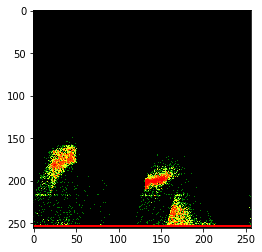

In [388]:
#img = imread(target_data_set_dir+'/Noise_20200528161000_0_img.bmp')
img = imread('PDImages/20201106_images/Void/Void_AD10A6220201106152700_1_img.bmp')

plt.imshow(img)

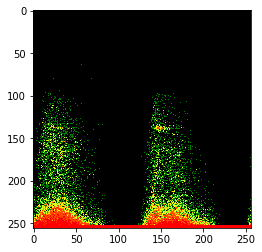

In [144]:
#img = imread(target_data_set_dir+'/Noise_20200528161000_0_img.bmp')
img = imread(target_data_set_dir+'/Surface_20200528145500_2_img.bmp')

plt.imshow(img)

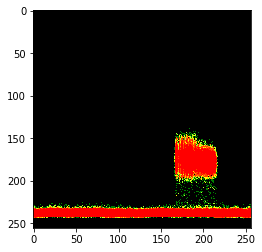

In [176]:
#img = imread(target_data_set_dir+'/Noise_20200528161000_0_img.bmp')
img = imread('PDImages/20201105_Corona_samples_1/Corona_20201106143000_3_img.bmp')

plt.imshow(img)

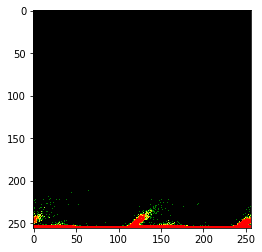

In [61]:
#img = imread(target_data_set_dir+'/Noise_20200528161000_0_img.bmp')
img = imread(target_data_set_dir2+'/Void_20201105170900_1_img.bmp')

plt.imshow(img)

In [ ]:
model.layers[89].output

In [ ]:
print(model.inputs)
print(model.outputs)
model.layers[88].output

In [ ]:
inputs = {'input': model.inputs[0]},
outputs = {'class_output' : model.outputs[0], 'feature_output' :model.layers[88].output}

In [ ]:
def display_nodes(graph): 
    for i, node in enumerate(graph.node): 
        print('%d %s %s' % (i, node.name, node.op)) 
        [print(u'└─── %d ─ %s' % (i, n)) 
         for i, n in enumerate(node.input)]

In [ ]:
display_nodes(tf.get_default_graph().as_graph_def())

### Model save using tensorflow save module

In [ ]:
#kb.set_learning_phase(0)
#tf.keras.backend.set_learning_phase(0)
#model.trainable = False
tf.saved_model.simple_save(kb.get_session(), '2020_models/2020_mobil_new_simple_save_20201123_small_mbile_base_01_acc_99.8_val_loss_0.64', 
                           inputs={'image_input': model.inputs[0]}, 
                           outputs={'class_output' : model.outputs[0],
                                    'feature_output' :model.layers[88].output})

### Model save using keras save module

In [173]:
#model.trainable = False
model.save(filepath='2020_models/2020_mobil_new_simple_save_20201123_small_mbile_base_01_acc_100_val_loss_0.59_batch_200')